In [134]:
import numpy as np
import os
import logging
from anytree import Node, RenderTree

# from cocluster import Cocluster

class DataStorage:
    def __init__(self):
        self.data = {}
        self.key_map = {}

    def load_data(self, np_data):
        """从numpy数组加载数据"""
        if isinstance(np_data, np.ndarray) and np_data.size == 1 and isinstance(np_data.item(), dict):
            self.data = np_data.item()
            self._create_key_map()
        else:
            raise ValueError("Invalid data format. Expected a numpy array containing a dictionary.")

    def _create_key_map(self):
        """创建 key_map, 将每个键映射到唯一的数字索引"""
        self.key_map = {key: idx for idx, key in enumerate(self.data.keys())}

    def get_data_by_key(self, key):
        """通过键获取数据"""
        return self.data.get(key, None)

    def get_data_by_index(self, index):
        """通过索引获取数据"""
        key = self.get_key_by_index(index)
        return self.get_data_by_key(key)

    def get_key_by_index(self, index):
        """通过索引获取键"""
        return next((key for key, idx in self.key_map.items() if idx == index), None)

    def get_all_keys(self):
        """获取所有数据键"""
        return list(self.data.keys())

    def print_data(self):
        """打印所有数据"""
        for key, value in self.data.items():
            print(f"{key}: {value}")
            

def build_forest(keys):
    # 按键长度排序
    sorted_keys = sorted(keys, key=len)
    nodes = {}
    
    for key in sorted_keys:
        # 初始化节点
        node = Node(key)
        nodes[key] = node
        
        # 找到最长匹配前缀作为父节点
        for i in range(len(key)-1, 0, -1):
            parent_key = key[:i]
            if parent_key in nodes:
                node.parent = nodes[parent_key]
                break

    return nodes

def print_subtree(node):
    """打印以指定节点为根的子树"""
    for pre, fill, child in RenderTree(node):
        print(f"{pre}{child.name}")
        if hasattr(child, 'data') and child.data:
            print(f"{pre}Data: {child.data}")

def reorder_matrix(matrix, name_1, name_2):
    """
    根据 name_2 中的顺序对 matrix (对应 name_1) 进行重新排列，并删除不在 name_2 中的部分。

    :param matrix: 需要重新排列的矩阵
    :param name_1: 矩阵的原始行列标签
    :param name_2: 新的行列标签顺序
    :return: 重新排列后的矩阵
    """
    # 找到 name_2 中元素在 name_1 中的位置
    indices = [np.where(name_1 == name)[0][0] for name in name_2 if name in name_1]

    return matrix[indices, :][:, indices]
            
HOME = os.environ['HOME'] + '/'
datapath = f'{HOME}dataset/zhaokedata'
file_list = os.listdir(datapath)
# remove all '._' files
file_list = [f for f in file_list if not f.startswith('._')]

logging.basicConfig(level=logging.INFO)
logging.info(f'file_list: {file_list}')

# INFO:root:file_list: ['200113plc1p2.npy', '200113plc1p2_TD.npy', '200323plc1p1_Names.npy', '200113plc1p2_Names.npy', '200323plc1p1_TD.npy']

# get size of each file
# for f in file_list:
#     np_data = np.load(f'{datapath}/{f}', allow_pickle=True)
#     logging.info(f'{f}: {np_data.shape}')
    

INFO:root:file_list: ['191108plc1p1.rar', '200113plc1p2.npy', '200113plc1p2_TD.npy', '191108plc1p1', '200323plc1p1_Names.npy', '200113plc1p2.rar', '200113plc1p2_Names.npy', '200323plc1p1_TD.npy', '200113plc1p2']


In [135]:
np_data = np.load(
    '/home/zihan/codes/zhaokedata/200113plc1p21.npy', allow_pickle=True
)

# 创建DataStorage实例并加载数据
data_storage = DataStorage()
data_storage.load_data(np_data)

# 获取所有键并生成森林
all_keys = data_storage.get_all_keys()
nodes = build_forest(all_keys)

# 将数据添加到树节点中
for key, data in data_storage.data.items():
    nodes[key].data = data

# 找到所有根节点
roots = [node for node in nodes.values() if node.is_root]

# 打印森林结构和数据
# for root in roots:
#     for pre, fill, node in RenderTree(root):
#         print(f"{pre}{node.name}")
#         if hasattr(node, 'data') and node.data:
#             print(f"{pre}Data: {node.data}")
# 打印某个节点及其子树
print("\nSubtree rooted at 'AB':")
print_subtree(nodes['AB'])


Type of data: <class 'numpy.ndarray'>
Number of dimensions (ndim): 0
Shape of the array (shape): ()
Total number of elements (size): 1
Data type of elements (dtype): object
Size of each element (itemsize): 8 bytes
Total bytes of the array (nbytes): 8 bytes


In [137]:
# save key map to file that can read
with open('key_map.txt', 'w') as f:
    for k, v in data_storage.key_map.items():
        f.write(f'{k} {v}\n')

In [138]:
# 200113plc1p2_TD.npy, 200323plc1p1_TD.npy

matrix_1 = np.load(f'{datapath}/200113plc1p2_TD.npy', allow_pickle=True)
matrix_2 = np.load(f'{datapath}/200323plc1p1_TD.npy', allow_pickle=True)

# 逐项 e^(x) 转换 并 normalize
matrix_1 = np.exp(matrix_1 / (np.max(matrix_1) + 1))
matrix_2 = np.exp(matrix_2 / (np.max(matrix_2) + 1))

# print max
print(f"Max value in matrix_1: {np.max(matrix_1)}")
print(f"Max value in matrix_2: {np.max(matrix_2)}")

# '200323plc1p1_Names.npy', '200113plc1p2_Names.npy'
name_1 = np.load(f'{datapath}/200113plc1p2_Names.npy', allow_pickle=True)
name_2 = np.load(f'{datapath}/200323plc1p1_Names.npy', allow_pickle=True)

# print shape of the two matrices
print(f"Shape of matrix_1: {matrix_1.shape}")
print(f"Shape of matrix_2: {matrix_2.shape}")

print(f"Shape of name_1: {name_1.shape}")
print(f"Shape of name_2: {name_2.shape}")

name_1[:10], name_2[:10]

Max value in matrix_1: 2.718186740016327
Max value in matrix_2: 2.7181578574792633
Shape of matrix_1: (1288, 1288)
Shape of matrix_2: (1208, 1208)
Shape of name_1: (1288,)
Shape of name_2: (1208,)


(array(['AB', 'P1', 'ABa', 'ABp', 'EMS', 'P2', 'ABal', 'ABar', 'ABpl', 'ABpr'], dtype='<U12'),
 array(['ABa', 'ABp', 'EMS', 'P2', 'ABal', 'ABar', 'ABpl', 'ABpr', 'E', 'MS'], dtype='<U12'))

In [139]:
# name_1 和 name_2 里面有很多相同的key, 给出相同的 map, 计算重合覆盖率

mapping = {}
same_count = 0

for i in range(len(name_1)):
    if name_1[i] in name_2:
        j = np.where(name_2 == name_1[i])[0][0]
        # print(f'{name_1[i]}: {i} {j}')
        mapping[name_1[i]] = (i, j)
        same_count += 1

print(f"Number of common keys: {same_count}")
print(f"Mapping: {mapping}")

print(f"Overlap coverage_1: {same_count / len(name_1):.2f}")
print(f"Overlap coverage_2: {same_count / len(name_2):.2f}")


Number of common keys: 1208
Mapping: {'ABa': (2, 0), 'ABp': (3, 1), 'EMS': (4, 2), 'P2': (5, 3), 'ABal': (6, 4), 'ABar': (7, 5), 'ABpl': (8, 6), 'ABpr': (9, 7), 'E': (10, 8), 'MS': (11, 9), 'P3': (12, 10), 'C': (13, 11), 'ABala': (14, 18), 'ABalp': (15, 19), 'ABara': (16, 12), 'ABarp': (17, 13), 'ABpla': (18, 14), 'ABplp': (19, 15), 'ABpra': (20, 16), 'ABprp': (21, 17), 'MSa': (22, 20), 'MSp': (23, 21), 'Ea': (24, 22), 'Ep': (25, 23), 'Ca': (26, 24), 'Cp': (27, 25), 'ABalaa': (28, 30), 'ABalap': (29, 31), 'ABalpa': (30, 32), 'ABalpp': (31, 33), 'ABaraa': (32, 34), 'ABarap': (33, 35), 'ABarpa': (34, 36), 'ABarpp': (35, 37), 'ABplaa': (36, 38), 'ABplap': (37, 39), 'ABpraa': (38, 26), 'ABprap': (39, 27), 'ABplpa': (40, 40), 'ABplpp': (41, 41), 'ABprpa': (42, 42), 'ABprpp': (43, 43), 'P4': (44, 28), 'D': (45, 29), 'MSaa': (46, 44), 'MSap': (47, 45), 'MSpa': (48, 46), 'MSpp': (49, 47), 'Cpa': (50, 50), 'Cpp': (51, 51), 'Caa': (52, 48), 'Cap': (53, 49), 'ABalaaa': (54, 56), 'ABalaap': (55, 5

In [140]:
reordered_matrix = reorder_matrix(matrix_1, name_1, name_2)

print(f"Shape of reordered matrix: {reordered_matrix.shape}")

tensor = np.stack([reordered_matrix, matrix_2], axis=2)
print(f"Shape of tensor: {tensor.shape}")

Shape of reordered matrix: (1208, 1208)
Shape of tensor: (1208, 1208, 2)


In [141]:
import importlib
import cocluster
from cocluster import CoCluster
importlib.reload(cocluster)

ks = [2, 4, 6, 8, 16, 32, 64, 128, 256]
with open('tensor_0.txt', 'w') as f:
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            f.write(f'{tensor[i, j, 0]} ')
        f.write('\n')

with open('tensor_1.txt', 'w') as f:
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            f.write(f'{tensor[i, j, 1]} ')
        f.write('\n')
        
with open('sum_col_tensor_0.txt', 'w') as f:
    for i in range(tensor.shape[0]):
        f.write(f'{np.sum(tensor[i, :, 0])}\n')
        
with open('sum_row_tensor_0.txt', 'w') as f:
    for i in range(tensor.shape[1]):
        f.write(f'{np.sum(tensor[:, i, 0])}\n')

Results written to cocluster.txt


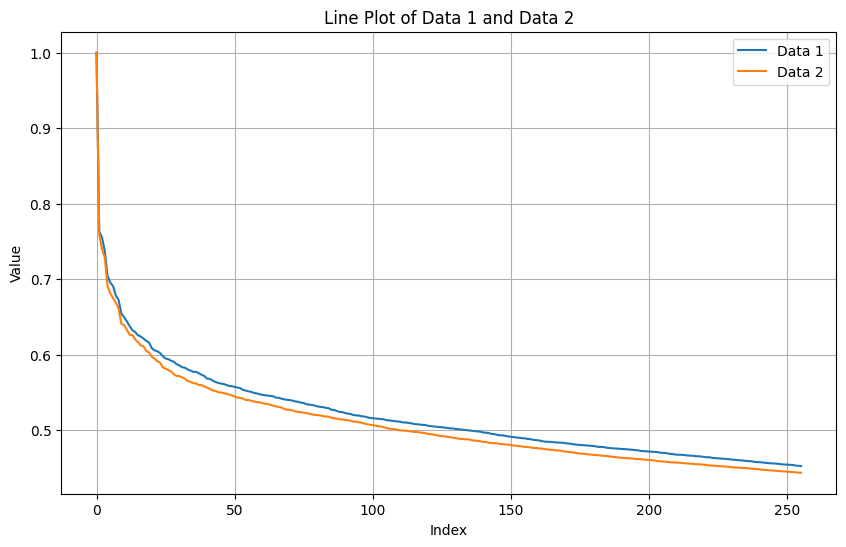

In [142]:
import importlib
import cocluster
from cocluster import CoCluster
importlib.reload(cocluster)

def format_array(arr):
    # 将数组转化为字符串，并确保完整输出
    return np.array2string(arr, separator=', ', max_line_width=np.inf)

# 设置 NumPy 打印选项以确保完整打印数组
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

with open('cocluster.txt', 'w') as f:
    for k in ks:
        f.write(f'k={k}\n')
        cocluster_1 = CoCluster(tensor[:, :, 0], k)
        _, label_u_1, label_v_1 = cocluster_1.co_cluster()
        f.write(f'label_u_1:\n{format_array(label_u_1)}\n')
        f.write(f'label_v_1:\n{format_array(label_v_1)}\n')
        _, S1, _ = cocluster_1.co_SVD()
        # write S1
        f.write(f'S1:\n{format_array(S1)}\n')
        
        cocluster_2 = CoCluster(tensor[:, :, 1], k)
        _, label_u_2, label_v_2 = cocluster_2.co_cluster()
        f.write(f'label_u_2:\n{format_array(label_u_2)}\n')
        f.write(f'label_v_2:\n{format_array(label_v_2)}\n')
        _, S2, _ = cocluster_2.co_SVD()
        # write S2
        f.write(f'S2:\n{format_array(S2)}\n')

print("Results written to cocluster.txt")

import matplotlib.pyplot as plt


# x ^ -10
S1 = np.power(S1, 1/10)
S2 = np.power(S2, 1/10)

plt.figure(figsize=(10, 6))
plt.plot(S1, label='Data 1')
plt.plot(S2, label='Data 2')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot of Data 1 and Data 2')
plt.legend()
plt.grid(True)
plt.show()
